## Optimal pooling

In [1]:
import utils as ut
import optimal_binning as ob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from statsmodels.stats.proportion import proportions_ztest
import numpy as np

### A. Generate the synthetic dataset

In [2]:
# Generate dataset
generator = ut.SyntheticDatasetGenerator(n_samples=1_000_000)
generator.generate_dataset()
df = generator.fit_logistic_regression()

df.head()

,x1,x2,year,target,score
0,0.958646,0.838719,2020,0,0.194613
1,-0.094752,-0.498360,2019,0,0.005142
2,1.552740,-0.543556,2015,0,0.092111
3,0.093803,-0.791283,2011,0,0.004804
4,0.259901,-0.520167,2010,0,0.009551


### B. Create raw bins for optimisation task

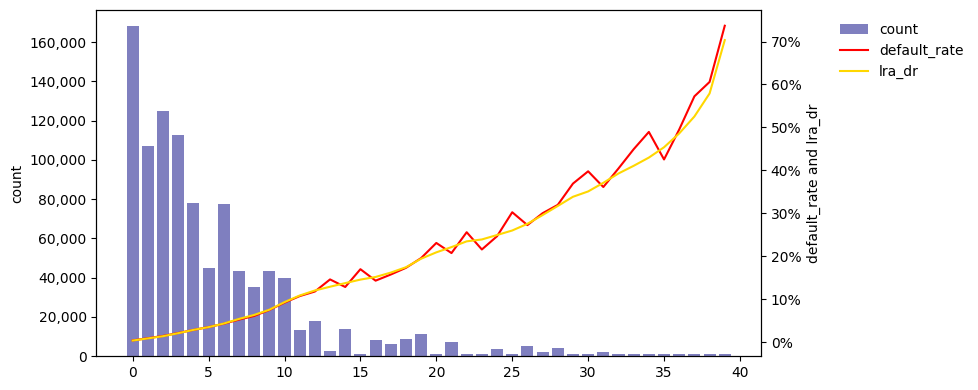

In [3]:
# Generate bins
optimal_binning = ob.BinningOptimizer()
df2, raw_df = optimal_binning.create_raw_bins(
    df, 
    n_bins=40,
    method="tree", # Options: ('tree', 'qcut', 'cut')
    min_samples_leaf=1000
)

# Get input data per bin
ut.plot_stats(df2)

### C. Create optimal bins

In [4]:
# Test solution
bins, _, _, iv, bin_data, excluded = optimal_binning.create_pools(min_bins=5,
                                                                  max_bins=20, 
                                                                  monotonical=True)

Total IV = 1.60, optimal solution
Function create_pools peaked at 57.67 MB.
Function create_pools executed in 5.71 seconds.


In [5]:
# Final solution
df_final = optimal_binning.get_dataframe()
df_final.head()

,x1,x2,year,target,score,bins,new_bin
0,0.958646,0.838719,2020,0,0.194613,19,13
1,-0.094752,-0.498360,2019,0,0.005142,0,0
2,1.552740,-0.543556,2015,0,0.092111,10,9
3,0.093803,-0.791283,2011,0,0.004804,0,0
4,0.259901,-0.520167,2010,0,0.009551,1,1


### D. Analyse the solution

In [6]:
drs = df_final.pivot_table(index='year', columns='new_bin', values='target', aggfunc='mean', margins='all').T
drs.style.format("{:.2%}")

year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,All
new_bin,,,,,,,,,,,,,,
0,0.36%,0.35%,0.45%,0.42%,0.46%,0.49%,0.43%,0.42%,0.47%,0.40%,0.36%,0.44%,0.44%,0.42%
1,0.81%,0.96%,1.04%,0.88%,1.03%,0.84%,0.86%,1.08%,0.98%,0.90%,0.74%,0.85%,1.20%,0.94%
2,1.38%,1.77%,1.55%,1.46%,1.39%,1.68%,1.29%,1.47%,1.29%,1.68%,1.43%,1.41%,1.29%,1.47%
3,2.02%,2.14%,2.00%,2.39%,1.96%,2.04%,2.30%,2.20%,2.22%,2.46%,1.94%,2.10%,2.18%,2.15%
4,2.81%,3.11%,2.87%,3.23%,2.54%,2.91%,2.84%,2.58%,2.99%,2.69%,2.84%,3.00%,2.82%,2.86%
5,3.82%,3.51%,2.79%,3.76%,3.86%,3.98%,3.35%,3.71%,3.43%,3.83%,3.15%,3.45%,3.29%,3.53%
6,5.16%,4.39%,4.17%,4.33%,4.11%,4.21%,4.07%,3.86%,3.86%,4.58%,4.63%,4.16%,4.39%,4.30%
7,5.35%,5.58%,5.76%,5.14%,6.05%,5.75%,6.02%,5.67%,5.89%,5.29%,5.55%,5.74%,5.59%,5.64%
8,7.67%,6.82%,7.24%,7.75%,6.71%,7.69%,8.34%,6.58%,7.33%,7.82%,7.45%,8.28%,7.86%,7.50%


In [7]:
drs = df_final.pivot_table(index='year', columns='new_bin', values='target', aggfunc='count', margins='all').T
drs.style.format("{:,.0f}")

year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,All
new_bin,,,,,,,,,,,,,,
0,"12,899","13,016","12,945","13,018","12,895","12,985","12,855","12,831","12,863","12,994","12,898","12,888","12,819","167,906"
1,"8,364","8,317","8,347","8,328","8,164","8,263","8,068","8,236","8,230","8,197","8,145","8,232","8,242","107,133"
2,"9,653","9,676","9,638","9,582","9,606","9,583","9,692","9,705","9,727","9,504","9,459","9,589","9,642","125,056"
3,"8,680","8,747","8,841","8,486","8,574","8,645","8,665","8,732","8,568","8,658","8,766","8,796","8,594","112,752"
4,"5,842","6,119","5,921","6,068","6,093","5,913","6,055","6,055","5,883","6,135","5,981","6,037","5,912","78,014"
5,"3,582","3,395","3,445","3,514","3,418","3,467","3,490","3,368","3,410","3,420","3,556","3,478","3,462","45,005"
6,"5,968","5,963","6,017","6,008","5,912","5,826","5,877","5,984","6,010","5,912","6,051","5,907","6,020","77,455"
7,"5,944","6,008","6,143","6,068","6,067","6,066","6,082","6,015","5,940","6,028","6,041","6,135","6,087","78,624"
8,"3,325","3,402","3,384","3,393","3,295","3,303","3,262","3,374","3,344","3,336","3,397","3,320","3,433","43,568"


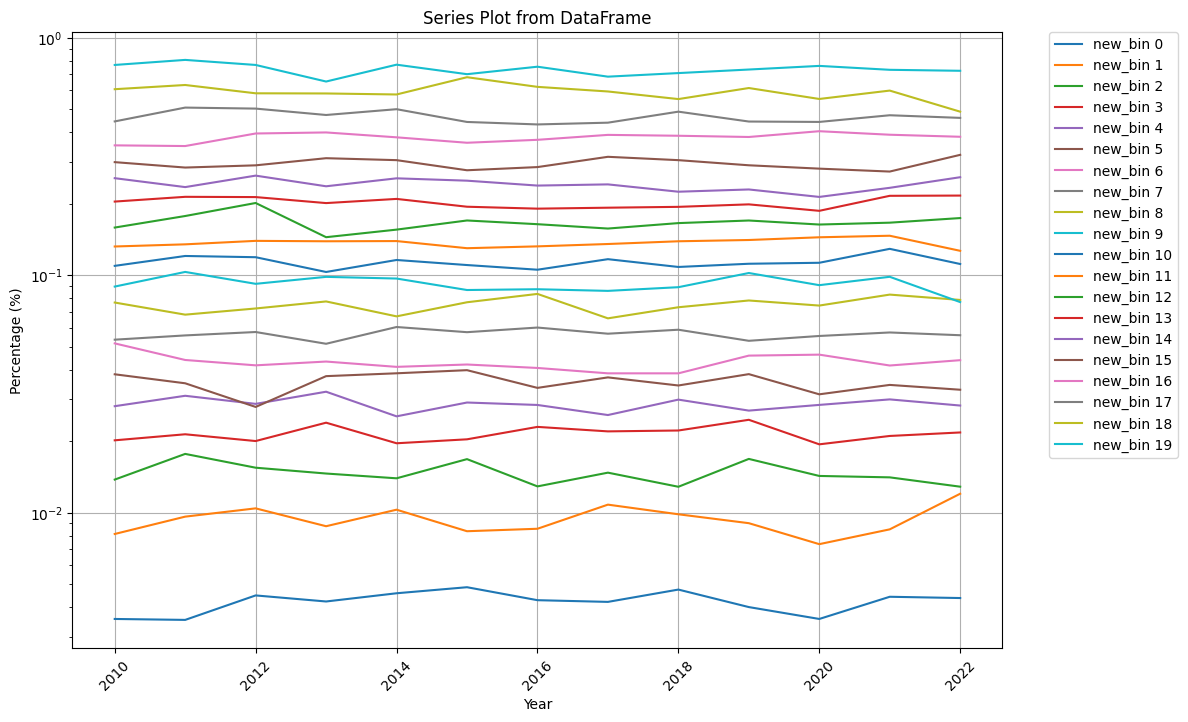

In [8]:
# Convert to DataFrame
df = df_final.pivot_table(index='year', columns='new_bin', values='target', aggfunc='mean')

# Plotting the DataFrame
plt.figure(figsize=(12, 8))

for row in df.columns:
    plt.plot(df.index, df[row], label=f'new_bin {row}')

# Set y-axis to logarithmic scale
plt.yscale('log')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Percentage (%)')
plt.title('Series Plot from DataFrame')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)

# Show plot
plt.show()


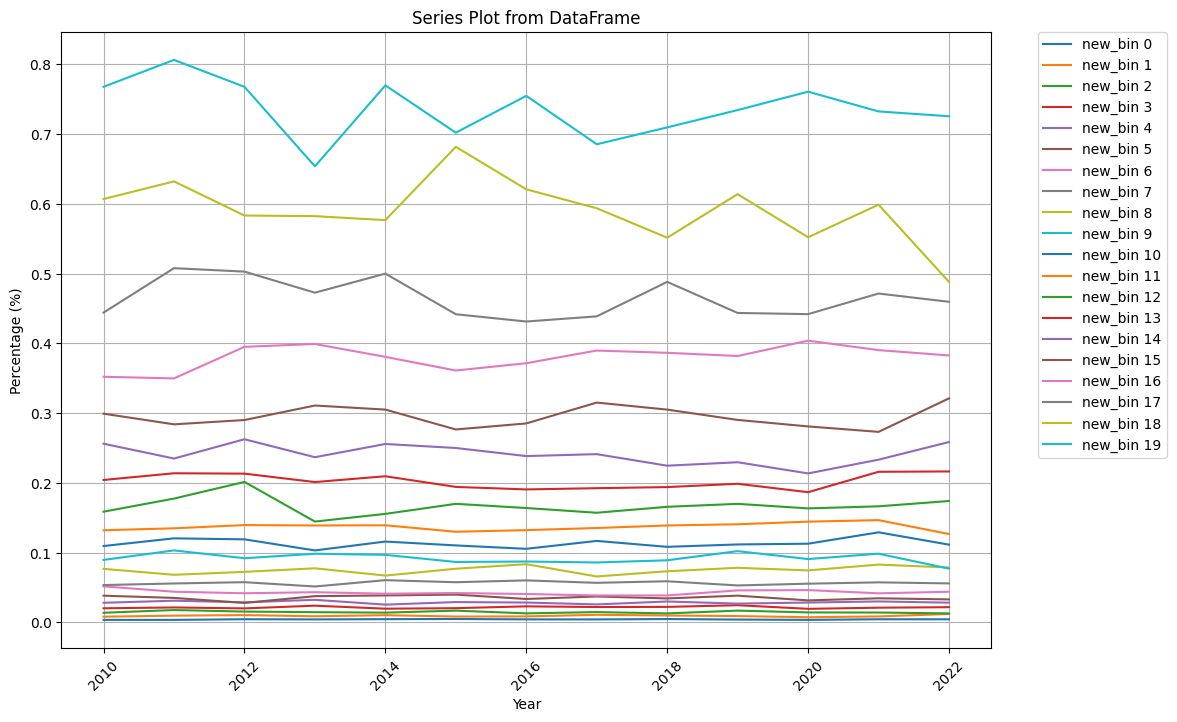

In [9]:
# Plotting the DataFrame
plt.figure(figsize=(12, 8))

for row in df.columns:
    plt.plot(df.index, df[row], label=f'new_bin {row}')

# Set y-axis to logarithmic scale
# plt.yscale('log')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Percentage (%)')
plt.title('Series Plot from DataFrame')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)

# Show plot
plt.show()

In [14]:
def heterogeneity_testing(df, outcome=None):
    results = pd.DataFrame(index=sorted(df['new_bin'].unique()), columns=sorted(df['year'].unique()))
    
    for year in df['year'].unique():
        yearly_data = df[df['year'] == year]
        bins = yearly_data['new_bin'].unique()
        
        for i in range(len(bins) - 1):
            bin1 = bins[i]
            bin2 = bins[i + 1]
            
            count = np.array([
                yearly_data[yearly_data['new_bin'] == bin1]['target'].sum(),
                yearly_data[yearly_data['new_bin'] == bin2]['target'].sum()
            ])
            
            nobs = np.array([
                yearly_data[yearly_data['new_bin'] == bin1].shape[0],
                yearly_data[yearly_data['new_bin'] == bin2].shape[0]
            ])
            
            stat, pval = proportions_ztest(count, nobs)
            if outcome == 'p_value':
                results.at[bin1, year] = pval
            else:
                results.at[bin1, year] = pval < 0.05
            
    
    return results

heterogeneity_testing(df_final, 'p_value')

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000013,0.0,0.000004
3,0.0,0.0,0.000635,0.0,0.0,0.0,0.038251,0.0,0.0,0.383818,0.000047,0.0,0.000376
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.242665,0.0,0.0,0.0,0.199567
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.000001,0.000107,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.210105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00002
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017248,0.0,0.0


In [15]:
heterogeneity_testing(df_final)

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,True,True,True,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,False,True,True,True
4,True,True,True,True,True,True,True,True,True,True,True,True,True
5,True,True,True,True,True,True,True,True,False,True,True,True,False
6,True,True,True,True,True,True,True,True,True,True,True,True,True
7,True,True,True,True,True,True,True,True,True,True,True,True,True
8,True,True,True,True,False,True,True,True,True,True,True,True,True
9,True,True,True,True,True,True,True,True,True,True,True,True,True
